## Automate the diagnosis of Knee Injuries 🏥 :|| an overview of the MRNet Dataset


###  Anterior Cruciate Ligament (ACL) tears

    
   ACL tears happen when the anterior cruciate ligament is either __stretched__, __partially torn__ , or __completely torn__. The most common injury is a complete tear.

### Let's summarize the problem 

![](https://www.ahmedbesbes.com/static/d15fa68246d268b4d8325ced47f1c4f4/b9e4f/overview.png)

### MRNet dataset


- It's splitted in __training set (1130 cases)__ , __validation set (120 cases)__ and `test set (120 cases)` and is organized as follows:

![](https://www.ahmedbesbes.com/static/9c81dc9b15b2f52e36e7cdd1c1679b3f/b9e4f/structure.png)



- __train-acl.csv__ and __valid-acl.csv__  indicate the labels of each case.

- Each case, in both train and valid folder, has 3 MRI scans taken from different planes: `sagittal, coronal and axial`.

![](https://www.ahmedbesbes.com/static/cc54ab6ef2b096a065a82431e15a8e6d/67f41/knee_mri_planes.png)




## Explore the MRNet dataset

In [1]:
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi=False

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, IntSlider
from tqdm import tqdm_notebook


train_acl = pd.read_csv('../data/train-acl.csv', header=None,
                       names=['Case', 'Abnormal'], 
                       dtype={'Case': str, 'Abnormal': np.int64})

train_acl.head()

,Case,Abnormal
0,0000,0
1,0001,1
2,0002,0
3,0003,0
4,0004,0


> ACL tears appears in less than __20%__ of the cases for the training set.



In [2]:
train_acl.Abnormal.value_counts(normalize=True)

0    0.815929
1    0.184071
Name: Abnormal, dtype: float64

Each MRI scan is a tensor of __s__ slices. 
    
    > Each slice is a grayscale image of size (256, 256).

- Let's Figure shape of each case on each plane 

- Let's  Visualize the first one on each plane:



In [3]:
case = '0000'

mri_coronal = np.load('../data/train/coronal/0000.npy')
mri_axial = np.load('../data/train/axial/0000.npy')
mri_sagittal = np.load('../data/train/sagittal/0000.npy')

print(f'MRI scan on coronal plane: {mri_coronal.shape}')
print(f'MRI scan on axial plane: {mri_axial.shape}')
print(f'MRI scan on sagittal plane: {mri_sagittal.shape}')

MRI scan on coronal plane: (36, 256, 256)
MRI scan on axial plane: (44, 256, 256)
MRI scan on sagittal plane: (36, 256, 256)


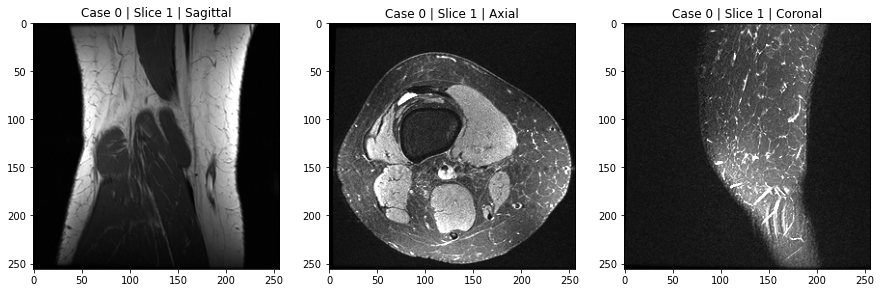

In [4]:
# To visualize

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(mri_coronal[0, :, :], 'gray');
ax1.set_title('Case 0 | Slice 1 | Sagittal');

ax2.imshow(mri_axial[0, :, :], 'gray');
ax2.set_title('Case 0 | Slice 1 | Axial');

ax3.imshow(mri_sagittal[0, :, :], 'gray');
ax3.set_title('Case 0 | Slice 1 | Coronal');


In [5]:
train_path = '../data/train/'

def load_one_stack(case, data_path=train_path, plane='coronal'):
    fpath = '{}/{}/{}.npy'.format(data_path, plane, case)
    return np.load(fpath)


def load_stacks(case, data_path=train_path):
    x = {}
    planes = ['coronal', 'sagittal', 'axial']
    for i, plane in enumerate(planes):
        x[plane] = load_one_stack(case, plane=plane)
    return x


def load_cases(train=True, n=None):
    assert (type(n) == int) and (n < 1250)
    if train:
        case_list = pd.read_csv('../data/train-acl.csv', names=['case', 'label'], header=None,
                               dtype={'case': str, 'label': np.int64})['case'].tolist()        
    else:
        case_list = pd.read_csv('../data/valid-acl.csv', names=['case', 'label'], header=None,
                               dtype={'case': str, 'label': np.int64})['case'].tolist()        
    cases = {}
    
    if n is not None:
        case_list = case_list[:n]
        
    for case in tqdm_notebook(case_list, leave=False):
        x = load_stacks(case)
        cases[case] = x
    return cases

cases = load_cases(n=100)


In [6]:
print(cases['0000'].keys())

dict_keys(['coronal', 'sagittal', 'axial'])


## Let's visualize each plane based on patient id or case



In [11]:
class KneePlot():
    def __init__(self, cases, figsize=(15, 5)):
        self.cases = cases
        
        self.planes = {case: ['coronal', 'sagittal', 'axial'] for case in self.cases}
    
        self.slice_nums = {}
        for case in self.cases:
            self.slice_nums[case] = {}
            for plane in ['coronal', 'sagittal', 'axial']:
                self.slice_nums[case][plane] = self.cases[case][plane].shape[0]

        self.figsize = figsize
        
    def _plot_slices(self, case, im_slice_coronal, im_slice_sagittal, im_slice_axial):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=self.figsize)
        
        ax1.imshow(self.cases[case]['coronal'][im_slice_coronal, :, :], 'gray')
        ax1.set_title(f'MRI slice {im_slice_coronal} on coronal plane')
        
        ax2.imshow(self.cases[case]['sagittal'][im_slice_sagittal, :, :], 'gray')
        ax2.set_title(f'MRI slice {im_slice_sagittal} on sagittal plane')
        
        ax3.imshow(self.cases[case]['axial'][im_slice_axial, :, :], 'gray')
        ax3.set_title(f'MRI slice {im_slice_axial} on axial plane')
        
        plt.show()
    
    def draw(self):
        case_widget = Dropdown(options=list(self.cases.keys()),
                               description='Case'
                              
                              )
        case_init = list(self.cases.keys())[0]


        slice_init_coronal = self.slice_nums[case_init]['coronal'] - 1        
        slices_widget_coronal = IntSlider(min=0, 
                                          max=slice_init_coronal, 
                                          value=slice_init_coronal // 2, 
                                          description='Coronal')
        
        slice_init_sagittal = self.slice_nums[case_init]['sagittal'] - 1        
        slices_widget_sagittal = IntSlider(min=0,
                                           max=slice_init_sagittal,
                                           value=slice_init_sagittal // 2,
                                           description='Sagittal'
                                          )
        
        slice_init_axial = self.slice_nums[case_init]['axial'] - 1        
        slices_widget_axial = IntSlider(min=0,
                                        max=slice_init_axial,
                                        value=slice_init_axial // 2,
                                        description='Axial'
                                       )
        
        def update_slices_widget(*args):
            slices_widget_coronal.max = self.slice_nums[case_widget.value]['coronal'] - 1
            slices_widget_coronal.value = slices_widget_coronal.max // 2
            
            slices_widget_sagittal.max = self.slice_nums[case_widget.value]['sagittal'] - 1
            slices_widget_sagittal.value = slices_widget_sagittal.max // 2
            
            slices_widget_axial.max = self.slice_nums[case_widget.value]['axial'] - 1
            slices_widget_axial.value = slices_widget_axial.max // 2
    
        
        case_widget.observe(update_slices_widget, 'value')
        interact(self._plot_slices,
                 case=case_widget, 
                 im_slice_coronal=slices_widget_coronal, 
                 im_slice_sagittal=slices_widget_sagittal, 
                 im_slice_axial=slices_widget_axial
                )
    
    def resize(self, figsize): 
        self.figsize = figsize

In [13]:
plot = KneePlot(cases)
plot.draw()

interactive(children=(Dropdown(description='Case', options=('0000', '0001', '0002', '0003', '0004', '0005', '0…

# MRNet architecture
    

### Code structure

 __The chart below summarizes pretty much the responsibility of each script.__

![](https://www.ahmedbesbes.com/static/fa13f43ec8f391739214a7db70408c9e/b9e4f/pipeline.png)

## 1 - The model architecture: model.py


> - Each MRI slice is passed through a feature extractor based on a pre-trained __AlexNet__ to obtain a `s x 256 x 7 x 7` out of  `s x 3 x 256 x 256` tensor containing features for each slice. 
- A __global average pooling__ layer is then applied to reduce these features to s x 256.
- A __max pooling__ across slices is applied to obtain a 256-dimensional vector which is passed a fully connected layer and sigmoid activation function to obtain a prediction between 0 an 1.



![](https://www.ahmedbesbes.com/static/d87acba7aceb0f592fcf3f6a78ea6510/b9e4f/mrnet_architecture.png)

### In the __constructor__ we define three objects:

 -   the pretrained AlexNet model
 -   the pooling layer
 -   the dense layer that acts as a classification layer
 

### In the forward method, 
    
    to  actually write the forward pass, i.e. the operations the network performs on the input until it computes the predictions.

Let's detail it step by step:

   - input x of shape (1, s, 256, 256, 3) 
   - removes the first dimension by __"squeezing"__
   - AlexNet which produces the features of shape (s, 256, 7, 7) 
   - __avrg pooling__ ->  features are pooled which produces an output of shape (s, 256)
   - fed to the classifier that outputs a scalar value

In [15]:
import torch
import torch.nn as nn
from torchvision import models

class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained_model = models.alexnet(pretrained=True)
        self.pooling_layer = nn.AdaptiveAvgPool2d(1)
        self.classifer = nn.Linear(256, 1)

    def forward(self, x):
        
        x = torch.squeeze(x, dim=0)  # removes the first dimension by __"squeezing"__
        
        features = self.pretrained_model.features(x) # AlexNet which produces the features of shape (s, 256, 7, 7)
        
        pooled_features = self.pooling_layer(features) # the features are pooled which produces an output of shape (s, 256)
        
        pooled_features = pooled_features.view(pooled_features.size(0), -1) #pooled features are __flattened__ in a 256 dimension vector 
        
        flattened_features = torch.max(pooled_features, 0, keepdim=True)[0]
        
        output = self.classifer(flattened_features)  # fed to the classifier that outputs a scalar value. 
        
        return output

### 2 - The custom dataset: dataloader.py


### In the constructor of MRDataset, we define a set of arguments:

   - root_dir  : ./data/
   - task      : either `acl, meniscus or abnormal`. we'll focus on acl in this post
   - plane     : either `sagittal, coronal or axial`.
 
   - train     : a boolean variable that indicates whether we are processing train data or not (validation)
   - transform : the series of data augmentation operations.



In the `__len__` function, we return the length of the data

In the `__getitem__` function we return the MRI scan .npy file, the label and the weight after applying minor preprocessing and eventual data augmentation.


In [17]:
class MRDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, task , plane, train=True, transform=None, weights=None):
        super().__init__()
        self.task = task
        self.plane = plane
        self.root_dir = root_dir
        self.train = train
        
        if self.train:
            self.folder_path = self.root_dir + '/train/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + '/train-{0}.csv'.format(task), header=None, names=['id', 'label'])
        
        else:
            transform = None
            self.folder_path = self.root_dir + '/valid/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + '/valid-{0}.csv'.format(task), header=None, names=['id', 'label'])
            
        self.records['id'] = self.records['id'].map(
            lambda i: '0' * (4 - len(str(i))) + str(i))

        self.paths = [self.folder_path + filename +'.npy' for filename in self.records['id'].tolist()]
        
        self.labels = self.records['label'].tolist()

        self.transform = transform
        
        """
        weights: custom weights for each class (default to None): 
        this is used to adjust the loss function. When None, weights are computed automatically.
        """
        if weights is None:
            pos = np.sum(self.labels)
            neg = len(self.labels) - pos
            self.weights = [1, neg / pos]
        else:
            self.weights = weights
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        array = np.load(self.paths[index])
        label = self.labels[index]
        label = torch.FloatTensor([label])
        
        if self.transform:
            array = self.transform(array)
        else:
            array = np.stack((array,)*3, axis=1)
            array = torch.FloatTensor(array)

        if label.item() == 1:
            weight = np.array([self.weights[1]])
            weight = torch.FloatTensor(weight)
        else:
            weight = np.array([self.weights[0]])
            weight = torch.FloatTensor(weight)

        return array, label, weight

## 3 - Where the training happens: train.py


- It imports `dataloader.py` to load the data from both train or validation sets.
- It imports `model.py` and instantiates an MRNet model before updating its weights.
- It launches a `training and validation` loop over a given number of __epochs__.

In [18]:
import shutil
import os
import time
from datetime import datetime
import argparse
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import RandomRotation , RandomAffine , Compose , ToTensor 
from torchvision.transforms import RandomAffine , RandomHorizontalFlip , RandomRotation ,Scale , ToTensor

from sklearn import metrics

In [19]:
## Updating the learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
task = 'acl'
plane = 'axial'
import os
dir_path = os.path.dirname(os.path.realpath('__file__'))
print(dir_path)

C:\Users\Dana\Desktop\Sentiment\ACL\data


## __`Evalution Function`__

In [22]:
def evaluate_model(model, val_loader, epoch, num_epochs, writer, current_lr, log_every=20):
    _ = model.eval()

    if torch.cuda.is_available():
        model.cuda()

    y_trues = []
    y_preds = []
    losses = []

    for i, (image, label, weight) in enumerate(val_loader):
        optimizer.zero_grad()

        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            weight = weight.cuda()

        label = label
        weight = weight

        prediction = model.forward(image.float())
        
        loss = torch.nn.BCEWithLogitsLoss(weight=weight)
        
        output = loss(prediction[0], label)

        loss_value = output.item()
        
        losses.append(loss_value)

        probas = torch.sigmoid(prediction)

        y_trues.append(int(label[0]))
        y_preds.append(probas[0].item())

        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5
        
        writer.add_scalar('Val/Loss', loss_value, epoch * len(val_loader) + i)
        writer.add_scalar('Val/AUC', auc, epoch * len(val_loader) + i)
        
        if (i % log_every == 0) & (i > 0):
            print('''[Epoch: {0} / {1} |Single batch number : {2} / {3} ] | avg val loss {4} | val auc : {5} | lr : {6}'''.
                  format(
                      epoch + 1,
                      num_epochs,
                      i,
                      len(val_loader),
                      np.round(np.mean(losses), 4),
                      np.round(auc, 4),
                      current_lr
                  )
                  )

    writer.add_scalar('Val/AUC_epoch', auc, epoch + i)

    val_loss_epoch = np.round(np.mean(losses), 4)
    val_auc_epoch = np.round(auc, 4)
    return val_loss_epoch, val_auc_epoch

## __`Training Function`__

In [23]:
def train_model(model, train_loader, epoch, num_epochs, optimizer, writer, current_lr, log_every=100):
    _ = model.train()
    
    if torch.cuda.is_available():
        model.cuda()
        
    y_preds = []
    y_trues = []
    losses = []
    
    for i, (image, label, weight) in enumerate(train_loader):
       
            
        optimizer.zero_grad()

        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            weight = weight.cuda()
        
        label = label
        weight = weight

        prediction = model.forward(image.float())
        
        loss = torch.nn.BCEWithLogitsLoss(weight=weight)
        
        output = loss(prediction[0], label)

        output.backward()
        optimizer.step()

        loss_value = output.item()
        losses.append(loss_value)

        probas = torch.sigmoid(prediction)

        y_trues.append(int(label[0]))
        y_preds.append(probas[0].item())
        
        
        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5

        
        writer.add_scalar('Train/Loss', loss_value,
                          epoch * len(train_loader) + i)
        writer.add_scalar('Train/AUC', auc, epoch * len(train_loader) + i)

        if (i % log_every == 0) & (i > 0):
            print('''[Epoch: {0} / {1} |Single batch number : {2} / {3} ]| avg train loss {4} | train auc : {5} | lr : {6}'''.
                  format(
                      epoch+1 ,
                      num_epochs,
                      i,
                      len(train_loader),
                      np.round(np.mean(losses), 4),
                      np.round(auc, 4),
                      current_lr
                  )
                  )

    writer.add_scalar('Train/AUC_epoch', auc, epoch + i)
    train_loss_epoch = np.round(np.mean(losses), 4)
    train_auc_epoch = np.round(auc, 4)
    return train_loss_epoch, train_auc_epoch

### __`To run th model`__

### The applied data augmentation

We'll sequentially apply 3 geometric transformations on each input MRI.

   - Random rotation between -25 and 25 degrees
   - Random shift in both direction between -25 and 25 pixels
   - Random horizontal flip with 50% probability

> Note that data augmentation is done identically over all the slices of an MRI.

In [24]:
def run(plane , task):
    
    log_root_folder = "./logs/{0}/{1}/".format(task, plane)
    
    ##  not used at the beginning
    if flush_history == 1:
        objects = os.listdir(log_root_folder)
        for f in objects:
            if os.path.isdir(log_root_folder + f):
                shutil.rmtree(log_root_folder + f)
                
    now = datetime.now()
    logdir = log_root_folder + now.strftime("%Y%m%d-%H%M%S") + "/"
    os.makedirs(logdir)
    writer = SummaryWriter(logdir)
    
    augmentor = Compose([
        transforms.Lambda(lambda x: torch.Tensor(x)),
        RandomRotation(25),
        transforms.Lambda(lambda x: torch.Tensor(x)[::-1]),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1, 1).permute(1, 0, 2, 3)),
    ])
    
    #<<<train>>
    train_dataset = MRDataset(dir_path,task , plane, train=True)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True, num_workers=11, drop_last=False)
    
     #<<<validation>>
    validation_dataset = MRDataset(dir_path,task, plane, train=False)
    validation_loader = torch.utils.data.DataLoader(
        validation_dataset, batch_size=1, shuffle=-True, num_workers=11, drop_last=False)

    mrnet = MRNet()
    
    if torch.cuda.is_available():
        mrnet = mrnet.cuda()
    
    lr= 1e-5
    ## torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizer = optim.Adam(mrnet.parameters(), lr= 1e-5,  weight_decay=0.1)
    
    """
    torch.optim.lr_scheduler provides several methods to adjust the learning rate based on the number of epochs.
    torch.optim.lr_scheduler.
    ReduceLROnPlateau allows dynamic learning rate reducing based on some validation measurements.
    
    """
    ## Parameters
    '''
    torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, 
    threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
    '''
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=.3,threshold=1e-4,verbose=True)

    best_val_loss = float('inf')
    best_val_auc = float(0)
    
    iteration_change_loss = 0
    patience =  5 ##args.patience
    log_every =  100 ##args.log_every
    num_epochs = 50
    
    t_start_training = time.time()

    
    for epoch in range(50):
        current_lr = get_lr(optimizer)
        t_start = time.time()

        train_loss, train_auc = train_model(mrnet, train_dataset, epoch, num_epochs, optimizer, writer , current_lr ,log_every)
        val_loss, val_auc = evaluate_model(mrnet, validation_dataset, epoch, num_epochs, writer , current_lr)
        
        
        t_end = time.time()
        delta = t_end - t_start
        
        print("train loss : {0} | train auc {1} | val loss {2} | val auc {3}".format(train_loss, train_auc, val_loss, val_auc))
        
        iteration_change_loss += 1
        print('-' * 30)
        
        ## 232 line
        prefix_name = ''

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            file_name =f'model_{prefix_name}_{task}_{plane}_val_auc_{val_auc:0.4f}_train_auc_{train_auc:0.4f}_epoch_{epoch+1}.pth'

            for f in os.listdir('./models/'):
                if (task in f) and (plane in f) and (prefix_name in f):
                        os.remove(f'./models/{f}')
                        
            torch.save(mrnet, f'./models/{file_name}')

        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            iteration_change_loss = 0

        if iteration_change_loss == patience:
            print('Early stopping after {0} iterations without the decrease of the val loss'.
                  format(iteration_change_loss))
            break
            
    t_end_training = time.time()
    print(f'training took {t_end_training - t_start_training} s')



On each epoch, many things are executed:

- We train the model using train_model
- We evaluate the model using evaluate_model
- We print the AUC metric and the loss on train and validation data
- We let the learning rate scheduler update the learning rate
    - if the validation AUC improves we checkpoint the model to disk
    - if the number of epochs without improvement of the loss is higher than the patience, we interrupt the training